In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(1, "../..")
from simulations import laub_loomis
from itertools import product
from prototype_nn import Splitting, predictions, tensor_flatten
import matplotlib.pyplot as plt
import prototype
import torch
%run ../utilities.ipynb

## Training : Simulations

In [2]:
training = pd.DataFrame(data = pd.read_csv("../../data/train/laub.csv"))
training.head()

,time,x,y,z,w,p,q,m,initial_x,initial_y,initial_z,initial_w,initial_p,initial_q,initial_m
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1,1,1,1,1
1,0.1,1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591,1,1,1,1,1,1,1
2,0.2,1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383,1,1,1,1,1,1,1
3,0.3,1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737,1,1,1,1,1,1,1
4,0.4,1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426,1,1,1,1,1,1,1


In [3]:
len(training)

640000

In [4]:
kfold = Splitting([0,8,9,10,11,12,13,14], [1,2,3,4,5,6,7], num_epoches = 5, batch_size = 32, lr= 0.00005)

In [5]:
evaluate = kfold.cross_validation_evaluate(training, 5)

------------- Fold 0 -------------
TEST: 0 TRAIN: [1, 2, 3, 4]
Epoch: 0  Train Loss: 0.00016614340711385012 
Epoch: 1  Train Loss: 0.00011178170097991824 
Epoch: 2  Train Loss: 2.5812163585214876e-05 
Epoch: 3  Train Loss: 0.00010885907977353781 
Epoch: 4  Train Loss: 0.00011050188186345622 
------------- Fold 1 -------------
TEST: 1 TRAIN: [0, 2, 3, 4]
Epoch: 0  Train Loss: 0.002388641005381942 
Epoch: 1  Train Loss: 0.00012447209155652672 
Epoch: 2  Train Loss: 0.0001279764255741611 
Epoch: 3  Train Loss: 0.0004646316228900105 
Epoch: 4  Train Loss: 0.00015446622273884714 
------------- Fold 2 -------------
TEST: 2 TRAIN: [0, 1, 3, 4]
Epoch: 0  Train Loss: 0.0009078249568119645 
Epoch: 1  Train Loss: 0.0005536018288694322 
Epoch: 2  Train Loss: 4.406875086715445e-05 
Epoch: 3  Train Loss: 5.501148916664533e-05 
Epoch: 4  Train Loss: 0.00010962363739963621 
------------- Fold 3 -------------
TEST: 3 TRAIN: [0, 1, 2, 4]
Epoch: 0  Train Loss: 2.7143440092913806e-05 
Epoch: 1  Train Loss

In [26]:
evaluate

[tensor(0.0004, grad_fn=<MseLossBackward>),
 tensor(0.0002, grad_fn=<MseLossBackward>),
 tensor(0.0001, grad_fn=<MseLossBackward>),
 tensor(0.0007, grad_fn=<MseLossBackward>),
 tensor(0.0001, grad_fn=<MseLossBackward>)]

In [27]:
average_loss = 0
for x in evaluate:
    average_loss += x.item()
average_loss/len(evaluate)

0.0003117238331469707

In [6]:
training['initial_parameters'] = list(zip(training.initial_x, 
                                          training.initial_y,
                                          training.initial_z,
                                          training.initial_w,
                                          training.initial_p,
                                          training.initial_q,))
training = training.drop(columns = ["initial_x","initial_y","initial_z","initial_w","initial_p","initial_q","initial_m"])
training.head()

,time,x,y,z,w,p,q,m,initial_parameters
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"(1, 1, 1, 1, 1, 1)"
1,0.1,1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591,"(1, 1, 1, 1, 1, 1)"
2,0.2,1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383,"(1, 1, 1, 1, 1, 1)"
3,0.3,1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737,"(1, 1, 1, 1, 1, 1)"
4,0.4,1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426,"(1, 1, 1, 1, 1, 1)"


In [7]:
initial = training[training["initial_parameters"] == (1, 1, 1, 1, 1, 1)]

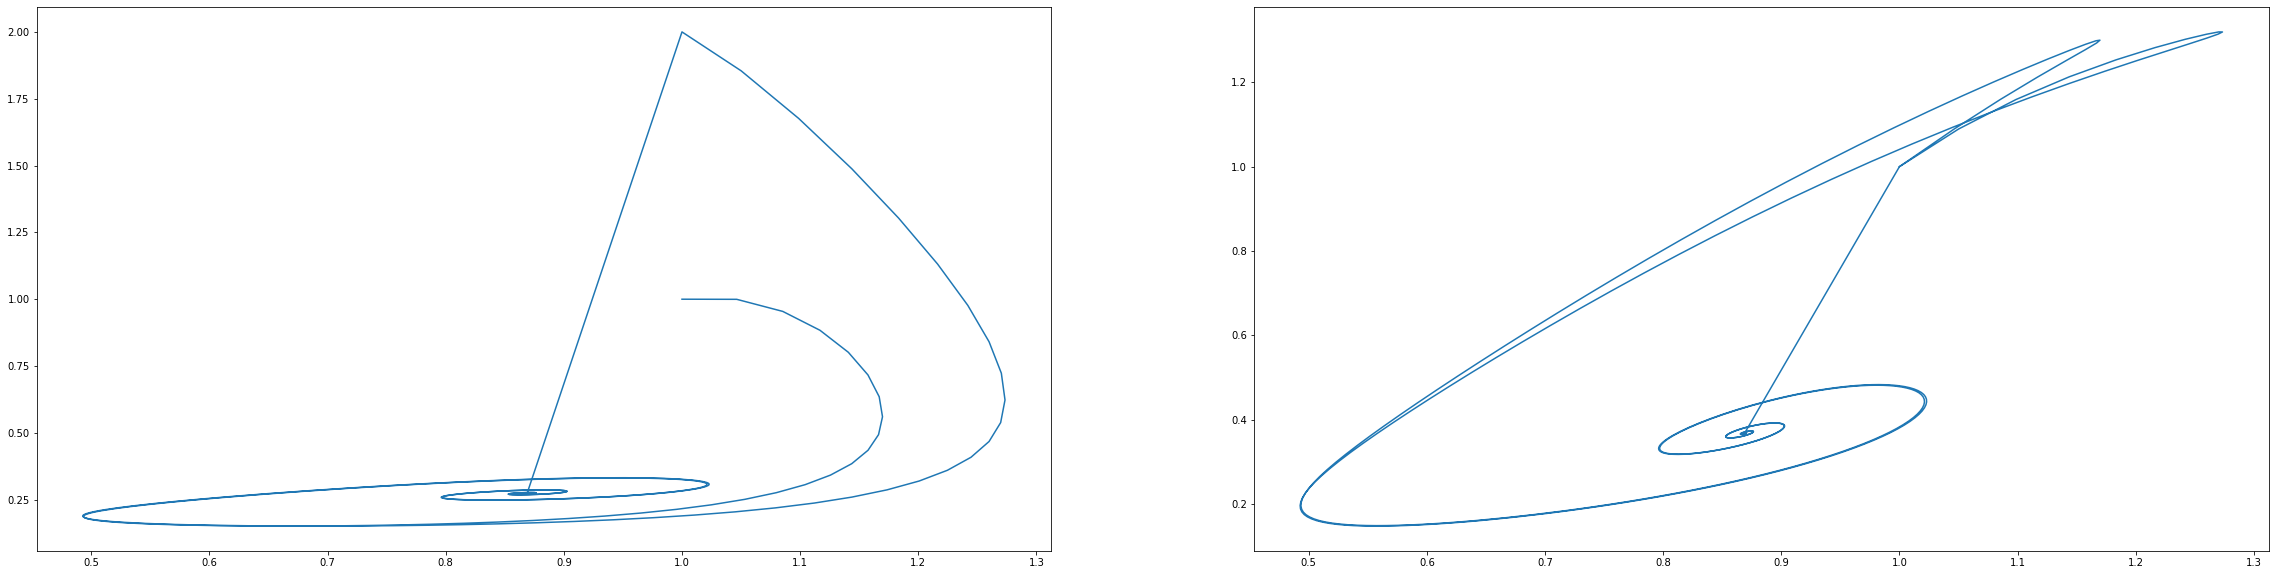

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(40,10))
ax[0].plot(initial[["x"]], initial[["m"]])
ax[1].plot(initial[["x"]], initial[["y"]])

## Training : Predictions

In [9]:
training_predictions = pd.DataFrame(data=pd.read_csv("../../data/train/laub.csv"))
training_predictions.head()

,time,x,y,z,w,p,q,m,initial_x,initial_y,initial_z,initial_w,initial_p,initial_q,initial_m
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1,1,1,1,1
1,0.1,1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591,1,1,1,1,1,1,1
2,0.2,1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383,1,1,1,1,1,1,1
3,0.3,1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737,1,1,1,1,1,1,1
4,0.4,1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426,1,1,1,1,1,1,1


In [10]:
training_predictions['initial_parameters'] = list(zip(training_predictions.initial_x, 
                                          training_predictions.initial_y,
                                          training_predictions.initial_z,
                                          training_predictions.initial_w,
                                          training_predictions.initial_p,
                                          training_predictions.initial_q,))
training_predictions = training_predictions.drop(columns = ["initial_x","initial_y","initial_z","initial_w","initial_p","initial_q","initial_m"])
training_predictions = training_predictions.rename(columns = {"x" : "x_preds", 
                                           "y" : "y_preds",
                                           "z" : "z_preds",
                                           "w" : "w_preds",
                                           "p" : "p_preds",
                                           "q" : "q_preds",
                                           "m" : "m_preds"})
training_predictions.head()

,time,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds,initial_parameters
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"(1, 1, 1, 1, 1, 1)"
1,0.1,1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591,"(1, 1, 1, 1, 1, 1)"
2,0.2,1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383,"(1, 1, 1, 1, 1, 1)"
3,0.3,1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737,"(1, 1, 1, 1, 1, 1)"
4,0.4,1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426,"(1, 1, 1, 1, 1, 1)"


In [11]:
training_and_predictions = pd.merge(training, training_predictions, right_on = ["time", "initial_parameters"],
                                    left_on = ["time", "initial_parameters"])

In [12]:
training_and_predictions.head()

,time,x,y,z,w,p,q,m,initial_parameters,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds
0,0.0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,"(1, 1, 1, 1, 1, 1)",1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
1,0.0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,"(1, 1, 1, 1, 1, 1)",1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,2.000000
2,0.0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,2.000000,"(1, 1, 1, 1, 1, 1)",1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
3,0.0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,2.000000,"(1, 1, 1, 1, 1, 1)",1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,2.000000
4,0.1,1.046344,1.089278,0.977479,1.067052,0.96984,0.759887,0.999591,"(1, 1, 1, 1, 1, 1)",1.046344,1.089278,0.977479,1.067052,0.96984,0.759887,0.999591


In [13]:
initial = training_and_predictions[training_and_predictions["initial_parameters"] == (1, 1, 1, 1, 1, 1)]

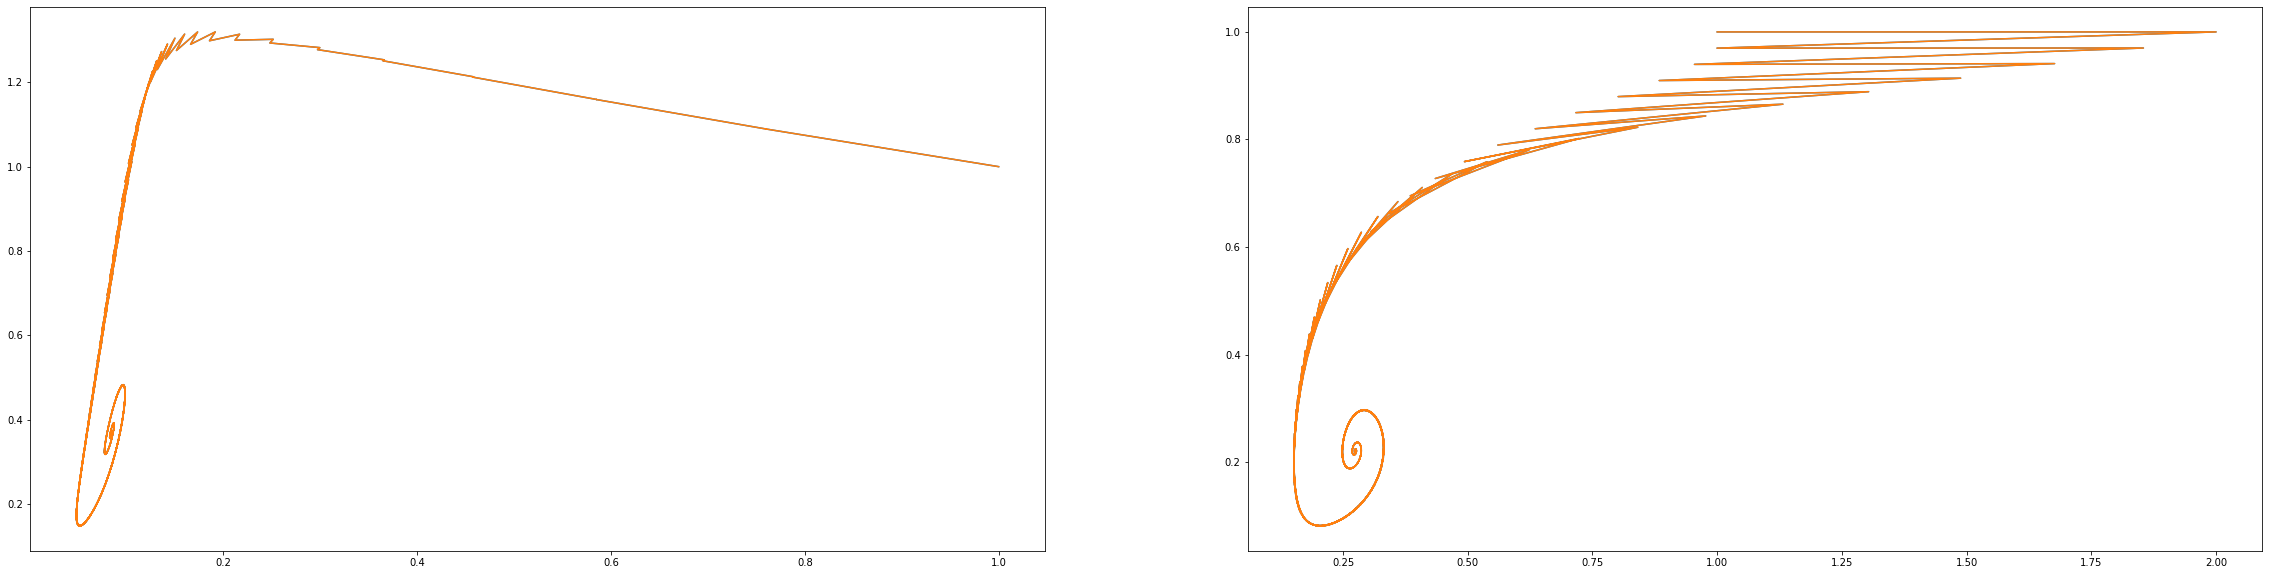

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(40,10))
ax[0].plot(initial[["q"]], initial[["y"]])
ax[0].plot(initial[["q_preds"]], initial[["y_preds"]])

ax[1].plot(initial[["m"]], initial[["p"]])
ax[1].plot(initial[["m_preds"]], initial[["p_preds"]])

## Testing : Simulations

In [47]:
testing = laub_loomis(delta = 0.1, simulations = 500, save = False, initial_paras = np.round(np.random.uniform(0, 4, 2), 2))
testing.head()

,time,x,y,z,w,p,q,m,initial_x,initial_y,initial_z,initial_w,initial_p,initial_q,initial_m
0,0.0,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,1.58,1.58,1.58,1.58,1.58,1.58,1.58
1,0.1,1.648177,1.711887,1.469983,1.477362,1.461555,1.200574,1.452072,1.58,1.58,1.58,1.58,1.58,1.58,1.58
2,0.2,1.695250,1.801893,1.353366,1.412558,1.374451,0.923755,1.280926,1.58,1.58,1.58,1.58,1.58,1.58,1.58
3,0.3,1.722489,1.861721,1.234977,1.378144,1.307536,0.721666,1.100679,1.58,1.58,1.58,1.58,1.58,1.58,1.58
4,0.4,1.731639,1.899284,1.118710,1.368376,1.253053,0.573897,0.930347,1.58,1.58,1.58,1.58,1.58,1.58,1.58


In [48]:
len(testing)

640000

In [49]:
testing['initial_parameters'] = list(zip(testing.initial_x, 
                                          testing.initial_y,
                                          testing.initial_z,
                                          testing.initial_w,
                                          testing.initial_p,
                                          testing.initial_q,))

In [50]:
testing.head()

,time,x,y,z,w,p,q,m,initial_x,initial_y,initial_z,initial_w,initial_p,initial_q,initial_m,initial_parameters
0,0.0,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,1.58,1.58,1.58,1.58,1.58,1.58,1.58,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
1,0.1,1.648177,1.711887,1.469983,1.477362,1.461555,1.200574,1.452072,1.58,1.58,1.58,1.58,1.58,1.58,1.58,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
2,0.2,1.695250,1.801893,1.353366,1.412558,1.374451,0.923755,1.280926,1.58,1.58,1.58,1.58,1.58,1.58,1.58,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
3,0.3,1.722489,1.861721,1.234977,1.378144,1.307536,0.721666,1.100679,1.58,1.58,1.58,1.58,1.58,1.58,1.58,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
4,0.4,1.731639,1.899284,1.118710,1.368376,1.253053,0.573897,0.930347,1.58,1.58,1.58,1.58,1.58,1.58,1.58,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"


In [51]:
def testing_preds(test_df):
    inputs = torch.tensor(test_df.iloc[ :, [0,8,9,10,11,12,13,14]].values)
    targets = torch.tensor(test_df.iloc[:, [1,2,3,4,5,6,7]].values)
    preds, _ = predictions(num_inputs=8, num_classes=7, learning_rate=0.0005, batch_size=1, num_epochs=1, inputs=inputs.float(), targets=targets.float(), train=False, path= "../../data/state/loomis.pth")
    data = {'time' : test_df.time.values,
            'initial_parameters' : test_df.initial_parameters.values,
            'x' : tensor_flatten(preds[:,0]), 'y' : tensor_flatten(preds[:, 1]), 
            'z' : tensor_flatten(preds[:, 2]), 'w' : tensor_flatten(preds[:, 3]),
            'p' : tensor_flatten(preds[:, 4]), 'q' : tensor_flatten(preds[:, 5]), 
            'm' : tensor_flatten(preds[:, 6])}
    return pd.DataFrame(data = data, columns = ["time", "x", "y", "z", "w", "p", "q", "m", "initial_parameters"]);

In [52]:
testing_predictions = testing_preds(testing)
testing_predictions.head()

,time,x,y,z,w,p,q,m,initial_parameters
0,0.0,1.581952,1.524140,1.703203,1.601777,1.504250,1.611513,1.845990,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
1,0.1,1.637705,1.615026,1.578152,1.544773,1.436735,1.410602,1.640993,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
2,0.2,1.693457,1.705912,1.453102,1.487767,1.369221,1.209691,1.435996,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
3,0.3,1.748919,1.795600,1.327174,1.431420,1.300921,1.007626,1.230466,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
4,0.4,1.801573,1.890020,1.194672,1.378485,1.231731,0.799851,1.020207,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"


In [53]:
testing = testing.drop(columns = ["initial_x","initial_y","initial_z","initial_w","initial_p","initial_q","initial_m"])
testing.head()

,time,x,y,z,w,p,q,m,initial_parameters
0,0.0,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
1,0.1,1.648177,1.711887,1.469983,1.477362,1.461555,1.200574,1.452072,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
2,0.2,1.695250,1.801893,1.353366,1.412558,1.374451,0.923755,1.280926,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
3,0.3,1.722489,1.861721,1.234977,1.378144,1.307536,0.721666,1.100679,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
4,0.4,1.731639,1.899284,1.118710,1.368376,1.253053,0.573897,0.930347,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"


In [54]:
testing_predictions = testing_predictions.rename(columns = {"x" : "x_preds", 
                                           "y" : "y_preds",
                                           "z" : "z_preds",
                                           "w" : "w_preds",
                                           "p" : "p_preds",
                                           "q" : "q_preds",
                                           "m" : "m_preds"})
testing_predictions.head()

,time,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds,initial_parameters
0,0.0,1.581952,1.524140,1.703203,1.601777,1.504250,1.611513,1.845990,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
1,0.1,1.637705,1.615026,1.578152,1.544773,1.436735,1.410602,1.640993,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
2,0.2,1.693457,1.705912,1.453102,1.487767,1.369221,1.209691,1.435996,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
3,0.3,1.748919,1.795600,1.327174,1.431420,1.300921,1.007626,1.230466,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
4,0.4,1.801573,1.890020,1.194672,1.378485,1.231731,0.799851,1.020207,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"


In [55]:
testing_and_predictions = pd.merge(testing, testing_predictions, right_on = ["time", "initial_parameters"],
                                    left_on = ["time", "initial_parameters"])

In [56]:
testing_and_predictions.head()

,time,x,y,z,w,p,q,m,initial_parameters,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds
0,0.0,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)",1.581952,1.524140,1.703203,1.601777,1.504250,1.611513,1.845990
1,0.0,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)",1.536589,1.308552,1.915714,1.655199,1.532073,2.109260,2.501759
2,0.0,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,3.580000,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)",1.581952,1.524140,1.703203,1.601777,1.504250,1.611513,1.845990
3,0.0,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,3.580000,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)",1.536589,1.308552,1.915714,1.655199,1.532073,2.109260,2.501759
4,0.1,1.648177,1.711887,1.469983,1.477362,1.461555,1.200574,1.452072,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)",1.637705,1.615026,1.578152,1.544773,1.436735,1.410602,1.640993


In [59]:
initial = testing_and_predictions[testing_and_predictions["initial_parameters"] == (1.58, 1.58, 1.58, 1.58, 1.58, 1.58)]

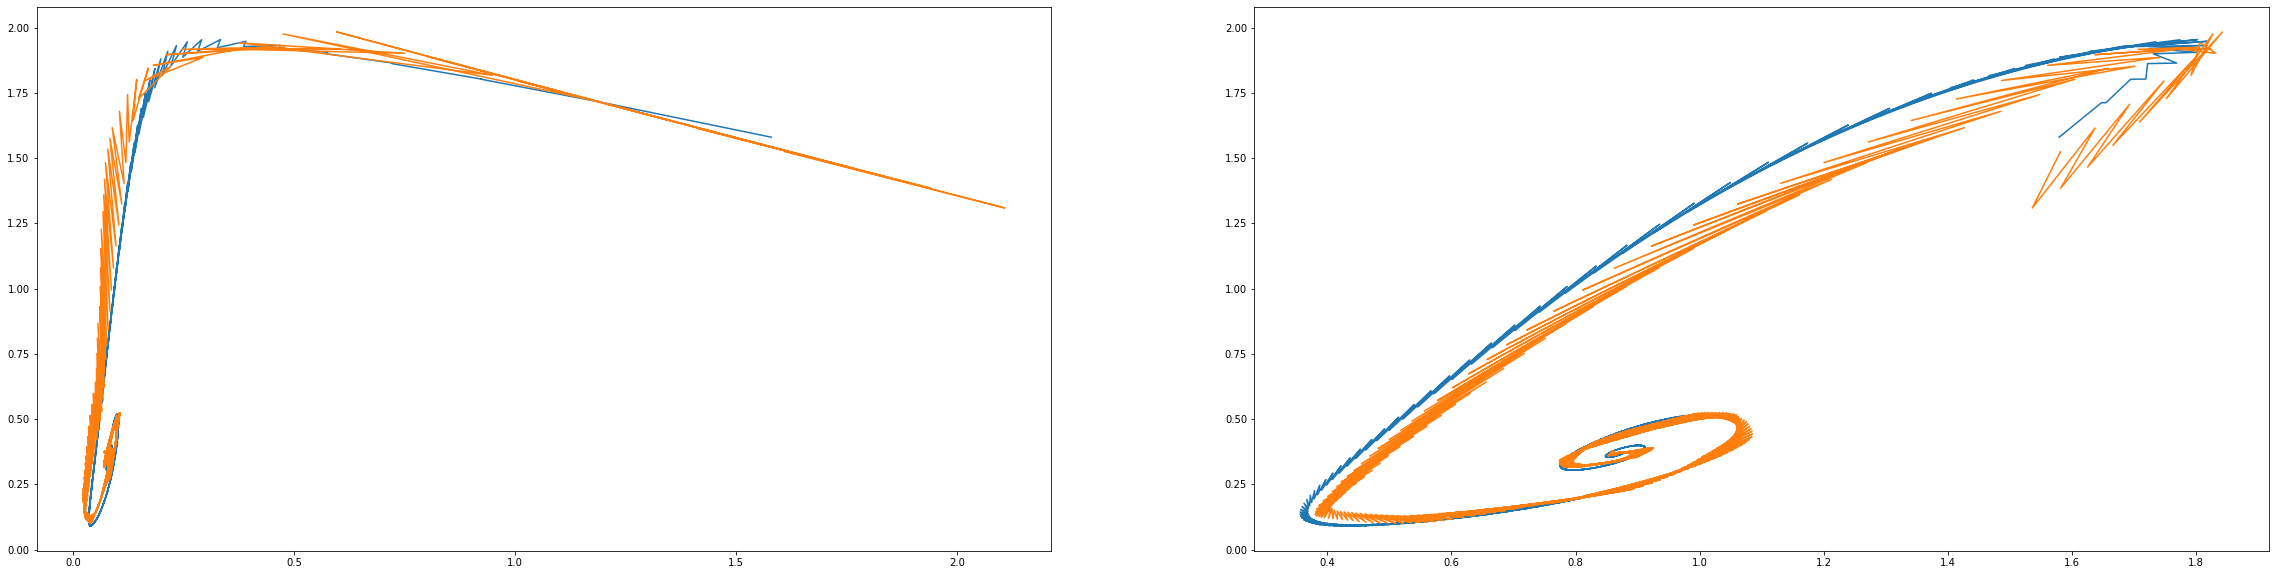

In [60]:
fig, ax = plt.subplots(ncols=2, figsize=(40,10))
ax[0].plot(initial[["q"]], initial[["y"]])
ax[0].plot(initial[["q_preds"]], initial[["y_preds"]])

ax[1].plot(initial[["x"]], initial[["y"]])
ax[1].plot(initial[["x_preds"]], initial[["y_preds"]])

### Loss by simulation

This is caculating the loss by testing simulation. This goes through every simulation within the testing data and caculates the loss.

Below are the dataframes where using: 
<ol>
    <li>testing - holds the testing simulations</li>
    <li> testing_predictions - holds the predictions of the testing simulation </li>
</ol>

In [74]:
testing.head()

,time,x,y,z,w,p,q,m,initial_parameters
0,0.0,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,1.580000,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
1,0.1,1.648177,1.711887,1.469983,1.477362,1.461555,1.200574,1.452072,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
2,0.2,1.695250,1.801893,1.353366,1.412558,1.374451,0.923755,1.280926,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
3,0.3,1.722489,1.861721,1.234977,1.378144,1.307536,0.721666,1.100679,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
4,0.4,1.731639,1.899284,1.118710,1.368376,1.253053,0.573897,0.930347,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"


In [62]:
testing_predictions.head()

,time,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds,initial_parameters
0,0.0,1.581952,1.524140,1.703203,1.601777,1.504250,1.611513,1.845990,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
1,0.1,1.637705,1.615026,1.578152,1.544773,1.436735,1.410602,1.640993,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
2,0.2,1.693457,1.705912,1.453102,1.487767,1.369221,1.209691,1.435996,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
3,0.3,1.748919,1.795600,1.327174,1.431420,1.300921,1.007626,1.230466,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"
4,0.4,1.801573,1.890020,1.194672,1.378485,1.231731,0.799851,1.020207,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)"


This is going through a function which caculates the loss for each simulation

In [63]:
simulationLoss, _ = lossBySimulations(testing, testing_predictions, [1,2,3,4,5,6,7])

The dataframe it provides, we see each simulation (initial_parameters) corresponds to a loss

In [64]:
simulationLoss.head()

,initial_parameters,Loss
0,1.58 1.58 1.58 1.58 1.58 1.58,0.000663
1,1.58 1.58 1.58 1.58 1.58 3.58,0.003153
2,1.58 1.58 1.58 1.58 3.58 1.58,0.001374
3,1.58 1.58 1.58 1.58 3.58 3.58,0.003269
4,1.58 1.58 1.58 3.58 1.58 1.58,0.001033


This function shows the plotted dataframe on the bar graph

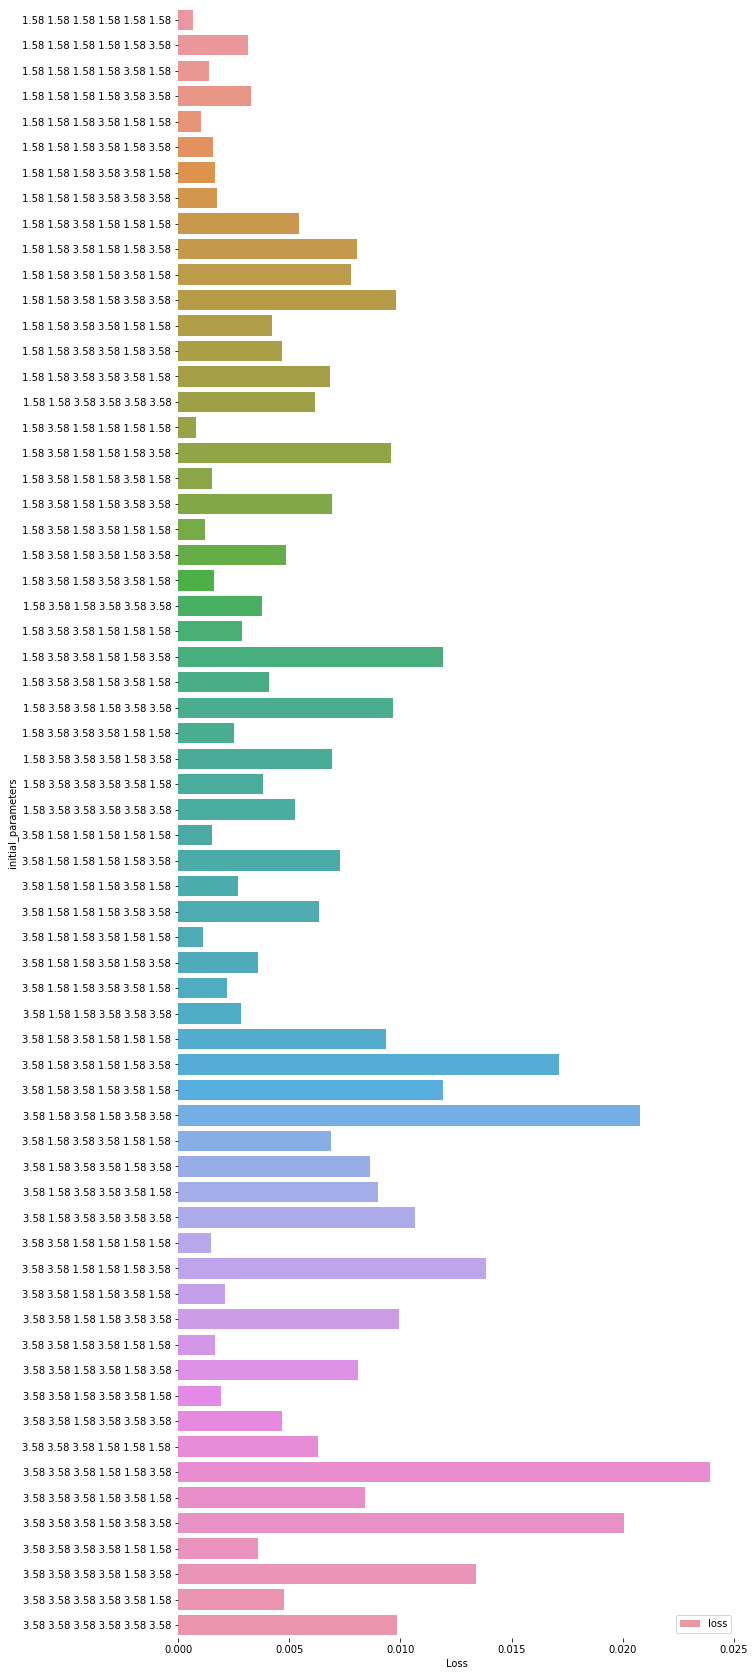

In [73]:
simulaPlots("Loss", "initial_parameters", simulationLoss, figsize = (10,30))

This is going through a function which allows us to see the loss for each individual time within the dataframe

In [66]:
timeLoss, _ = lossByTime(testing, testing_predictions, [1,2,3,4,5,6,7])

This returns a dataframe shown below

In [67]:
timeLoss.head()

,Time,initial_parameters,Loss
0,0.0,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)",0.013751
1,0.1,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)",0.015165
2,0.2,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)",0.018665
3,0.3,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)",0.016439
4,0.4,"(1.58, 1.58, 1.58, 1.58, 1.58, 1.58)",0.010062


This is the graph of the simulation

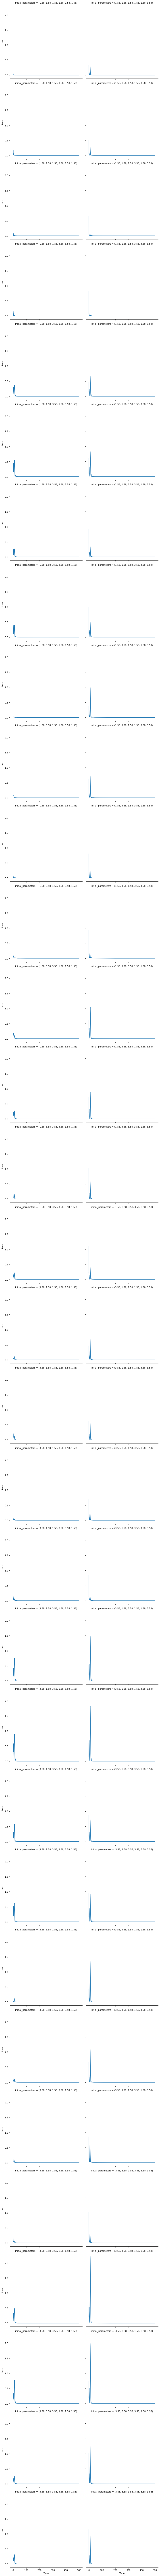

In [69]:
g = sns.FacetGrid(data = timeLoss, col = "initial_parameters", height = 5, col_wrap=2)
g.map(sns.lineplot, "Time", "Loss", ci=None)
g.add_legend()